# RDT y modelo Came

In [1]:
from hocelot.dlutils import read_raw_data

In [2]:
import os
import pickle
import joblib
import re
import string
import subprocess
import random
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import lightgbm
from xgboost import XGBClassifier
from multiprocessing import cpu_count
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve

from hocelot.dlutils import get_col_feats, read_raw_data
from hocelot.dlutils import open as open_dlutils # open for saving PKL
#from hocelot.dlutils.miscellaneous import RANDOM_SEED, hocelot_colors
from hocelot.rdt import RDTransformer
from hocelot.dlmodels import XGBClassifierSelector
from hocelot.dlplots import ModelResultsGrapher, ModelExplainabilityGrapher, DefaultGrapher
#from hocelot.dlplots.classification.general_plots import plot_target_stability
from hocelot.dlmetadata import HOCELOT_DTYPES, HOCELOT_FTYPES, LOG_TRANSFORMABLE_1

from hocelot.dlutils import open

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 100)

HOCELOT_YELLOW = '#FDD226'
HOCELOT_BLACK = '#000000'
HOCELOT_RED = '#FF5753'
HOCELOT_BLUE = '#2B3252'
HOCELOT_WHITE = '#FFFFFF'

%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import gcsfs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hocelot.dlutils import get_col_feats,open
from datetime import datetime
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 400)
pd.set_option('max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from hocelot.dlmetadata.hocelot_types import HOCELOT_DTYPES, HOCELOT_FTYPES
from hocelot.dlmetadata.log_transformable_features import LOG_TRANSFORMABLE_1, LOG_TRANSFORMABLE_2
from hocelot.rdt.models import RDTransformer
import joblib

In [4]:
def random_string(string_length=8):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))
    
def move_to_gs(file, bucket_path):
    process = subprocess.check_output(['gsutil', 'mv', file, bucket_path], stderr=subprocess.STDOUT)

def save_pkl(clf, file_object, file_name):
    model_pkl = file_object
    
    local_model_pkl = os.path.join('/tmp/', file_name + random_string())

    joblib.dump(clf, local_model_pkl)
    move_to_gs(local_model_pkl, model_pkl)

# 2. Load data

### 2.1. Preprocessed Data

In [5]:
preproc_data=pd.read_csv('gs://hocelot_mx_analytics/mexico/progress/mx-00007-Came/data_Came_post_enrich_con_target_v0.csv',sep=';', index_col=False)
print(preproc_data.shape)
preproc_data.head(2)

(13262, 146)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [6]:
preproc_data['Default_90_dias_pers'].isnull().sum()

0

In [7]:
preproc_data.head()

,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [8]:
target_cols = ['Default_90_dias_pers']

In [9]:
print('Size of dataset: {}'.format(preproc_data.shape))
100*preproc_data[target_cols[0]].value_counts()/preproc_data.shape[0]

Size of dataset: (13262, 146)


0   88.5613
1   11.4387
Name: Default_90_dias_pers, dtype: float64

# 3. RDT

### 3.1. Prepare data for Raw Data Transformation

In [10]:
data = preproc_data.copy()

In [11]:
print(data.shape)
data.head()

(13262, 146)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [12]:
mask = data.applymap(type) != bool
d = {True: 'true', False: 'false'}

data = data.where(mask, data.replace(d))

In [13]:
#HOCELOT_DTYPES['phoneValidation_internationalNumber']='object'
#HOCELOT_DTYPES['product_NVO']='object'
#HOCELOT_DTYPES['product_REN']='object'
HOCELOT_DTYPES['geoCheck_parsedAddress_zipCode']='object'
HOCELOT_DTYPES['economics_id']='object'
HOCELOT_DTYPES['economics_typeTable']='object'
HOCELOT_DTYPES['economics_personalData_ageIntervalMin']='object'
HOCELOT_DTYPES['economics_personalData_ageIntervalMax']= 'object'
HOCELOT_DTYPES['economics_personalData_bossEducation']='object' 
HOCELOT_DTYPES['economics_housingData_latitude']='object'
HOCELOT_DTYPES['economics_housingData_longitude']='object'
HOCELOT_DTYPES['economics_personalData_bossEducation']='int64' 
HOCELOT_DTYPES['economics_housingData_latitude']='object'
HOCELOT_DTYPES['Valor_producto']='float64'
HOCELOT_DTYPES['No_cuotas']='float64'
HOCELOT_DTYPES['Bureau_de_credito']='float64'

#HOCELOT_FTYPES['phoneValidation_internationalNumber']='categorical'
#HOCELOT_FTYPES['product_NVO']='categorical'
#HOCELOT_FTYPES['product_REN']='categorical'
HOCELOT_FTYPES['geoCheck_parsedAddress_zipCode']='categorical'
HOCELOT_FTYPES['economics_id']='categorical'
HOCELOT_FTYPES['economics_typeTable']='categorical'
HOCELOT_FTYPES['economics_personalData_ageIntervalMin']='categorical'
HOCELOT_FTYPES['economics_personalData_ageIntervalMax']= 'categorical'
HOCELOT_FTYPES['economics_personalData_bossEducation']='categorical' 
HOCELOT_FTYPES['economics_housingData_latitude']='categorical'
HOCELOT_FTYPES['economics_housingData_longitude']='categorical'
HOCELOT_FTYPES['Valor_producto']='numeric'
HOCELOT_FTYPES['No_cuotas']='numeric'
HOCELOT_FTYPES['Bureau_de_credito']='numeric'

LOG_TRANSFORMABLE = LOG_TRANSFORMABLE_1 + [
 'Monto',
 'Plazo',
 'Tasa',
 #'phoneVerification_imsi',
 #'phoneVerification_mnc',
 'geoCheck_score',
 'geoCheck_parsedAddress_zipCode',
 'economics_rent',
 'economics_personalData_work',
 'economics_personalData_possession',
 'economics_personalData_levelStudy',
 'economics_personalData_maritalStatus',
 'economics_personalData_probCouple',
 'economics_personalData_probDegree',
 'economics_personalData_probDivorced',
 'economics_personalData_probDoctorate',
 'economics_personalData_probHighschool',
 'economics_personalData_probMarried',
 'economics_personalData_probMasters',
 'economics_personalData_probNormal',
 'economics_personalData_probPreschool',
 'economics_personalData_probPrimary',
 'economics_personalData_probProfessional',
 'economics_personalData_probSecondary',
 'economics_personalData_probSeparated',
 'economics_personalData_probSingle',
 'economics_personalData_probWidower',
 'economics_personalData_probWithoutStudies',
 'economics_familyData_numberOfChild',
 'economics_familyData_numberOfDep',
 'economics_familyData_numberOfIndep',
 'economics_familyData_numberOfParents',
 'economics_familyData_numberOfYoungs',
 'economics_familyData_typeMember',
 'economics_housingData_numberHouseholdCars',
 'economics_housingData_numberHouseholdMembers',
 'economics_housingData_numberHouseholdMembersNoOutliers',
 'economics_housingData_numberIncandescentLights',
 'economics_housingData_numberLowConsumptionLights',
 'economics_housingData_numberRooms',
 'economics_housingData_bathShowerToilet',
 'economics_housingData_housingType',
 'economics_housingData_locationSize',
 'economics_housingData_codEntity',
 'economics_housingData_codMunicipality',
 'economics_housingData_codLocality',
 'economics_householdEconomy_probSaving',
 'economics_householdEconomy_probExpenseAlcoholAndTobacco',
 'economics_householdEconomy_probExpenseClothesAndFootwear',
 'economics_householdEconomy_probExpenseEducation',
 'economics_householdEconomy_probExpenseFinancial',
 'economics_householdEconomy_probExpenseFood',
 'economics_householdEconomy_probExpenseHealthCare',
 'economics_householdEconomy_probExpenseHealthInsurance',
 'economics_householdEconomy_probExpenseHomeRepair',
 'economics_householdEconomy_probExpenseHousesAndSupplies',
 'economics_householdEconomy_probExpenseLeisure',
 'economics_householdEconomy_probExpenseOthers',
 'economics_householdEconomy_probExpensePurchaseExp',
 'economics_householdEconomy_probExpenseRestaurants',
 'economics_householdEconomy_probExpenseTelco',
 'economics_householdEconomy_probExpenseTransport',
 'economics_householdEconomy_probExpenses',
 'economics_householdEconomy_incomeByRanges',
 'economics_householdEconomy_homeNetIncome',
 'economics_householdEconomy_effortRate',
 'economics_householdEconomy_newEffortRate',
 'economics_householdEconomy_povertyThreshold',
 'economics_householdEconomy_deposit',
 'economics_householdEconomy_sel',
 'economics_modelV1IndividualIncome',
 'economics_modelV2IndividualIncome',
 'economics_rawIndividualIncome',
 'economics_individualIncome',
 'geoCheck_parsedAddress_latitude',
 'geoCheck_parsedAddress_longitude'
]

In [14]:
mask = data.applymap(type) != bool
d = {True: 'true', False: 'false'}

data = data.where(mask, data.replace(d))

In [15]:
print(data.shape)
data.head()

(13262, 146)


,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [16]:
columns_for_rdt=data.columns.tolist()[12:16]+data.columns.tolist()[17:]

In [17]:
Cashmind_dtypes = { (key):('float64' if (data[key].dtype=='float64' or data[key].dtype=='int64')
          else 'object') for key in columns_for_rdt }

Cashmind_ftypes = { (key):('numeric' if (Cashmind_dtypes[key]=='float64' and data[key].nunique()>3)
          else 'categorical') for key in columns_for_rdt }

In [18]:
data = data.astype(Cashmind_dtypes)

In [19]:
rdt = RDTransformer(
    used_cols=columns_for_rdt, dtypes=Cashmind_dtypes, ftypes=Cashmind_ftypes, 
    log_transformable=LOG_TRANSFORMABLE_1)
rdt.check_raw_data(data)

True

In [20]:
data.head()

,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,pk,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [21]:
data.set_index('pk', inplace=True)

In [22]:
processed_data = rdt.transform(
    data, 
    fillna=False, 
    erase_outliers=False, 
    apply_pca=False,
    n_home_usages=20,
    alpha=3, 
    min_observations=200,
    max_categories=5,
    encoding='one-hot'
)
print(processed_data.shape)
processed_data.head()

Processing enrichment_home_usage: 0it [00:00, ?it/s]
Looking for redundant features: 100%|██████████| 74/74 [00:00<00:00, 147.32it/s]


(13262, 202)


,Monto_medio,Plazo_medio,Tasa_medio,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.householdEconomy.deposit,economics.householdEconomy.effortRate,economics.householdEconomy.homeNetIncome,economics.householdEconomy.incomeByRanges,economics.householdEconomy.newEffortRate,economics.householdEconomy.povertyThreshold,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.householdEconomy.probExpenseRestaurants,economics.householdEconomy.probExpenseTelco,economics.householdEconomy.probExpenseTransport,economics.householdEconomy.probExpenses,economics.householdEconomy.probSaving,economics.householdEconomy.sel,economics.housingData.bathShowerToilet,economics.housingData.codEntity,economics.housingData.codLocality,economics.housingData.codMunicipality,economics.housingData.housingType,economics.housingData.latitude,economics.housingData.locationSize,economics.housingData.longitude,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.id,economics.individualIncome,economics.modelV1IndividualIncome,economics.modelV2IndividualIncome,economics.rawIndividualIncome,economics.rent,economics.typeTable,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,geoCheck.parsedAddress.zipCode,geoCheck.score,fe_routlier_Monto_medio,fe_routlier_Plazo_medio,fe_missing_economics.familyData.numberOfChild,fe_loutlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDepYoung,fe_loutlier_economics.familyData.numberOfIndep,fe_routlier_economics.familyData.numberOfIndep,fe_loutlier_economics.familyData.numberOfParents,fe_routlier_economics.familyData.numberOfParents,fe_routlier_economics.householdEconomy.deposit,fe_routlier_economics.householdEconomy.effortRate,fe_routlier_economics.householdEconomy.homeNetIncome,fe_routlier_economics.householdEconomy.incomeByRanges,fe_routlier_economics.householdEconomy.newEffortRate,fe_routlier_economics.householdEconomy.povertyThreshold,fe_routlier_economics.householdEconomy.probExpenseAlcoholAndTobacco,fe_routlier_economics.householdEconomy.probExpenseClothesAndFootwear,fe_routlier_economics.householdEconomy.probExpenseEducation,fe_routlier_economics.householdEconomy.probExpenseFinancial,fe_routlier_economics.householdEconomy.probExpenseHealthCare,fe_routlier_economics.householdEconomy.probExpenseHealthInsurance,fe_routlier_economics.householdEconomy.probExpenseHomeRepair,fe_routlier_economics.householdEconomy.probExpenseHousesAndSupplies,fe_routlier_economics.householdEconomy.probExpenseLeisure,fe_routlier_economics.householdEconomy.probExpenseOthers,fe_routlier_economics.householdEconomy.probExpensePurchaseExp,fe_routlier_economics.householdEconomy.probExpenseRestaurants,fe_routlier_economics.householdEconomy.probExpenseTelco,fe_routlier_economics.householdEconomy.probExpenseTransport,fe_loutlier_economics.householdEconomy.probExpenses,fe_routlier_economics.householdEconomy.probExpenses,fe_loutlier_economics.householdEconomy.probSaving,fe_routlier_economics.householdEc

### 3.3. Save RDT and processed data

In [23]:
def random_string(string_length=8):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(string_length))
    
def move_to_gs(file, bucket_path):
    process = subprocess.check_output(['gsutil', 'mv', file, bucket_path], stderr=subprocess.STDOUT)

def save_pkl(clf, file_object, file_name):
    model_pkl = file_object
    
    local_model_pkl = os.path.join('/tmp/', file_name + random_string())

    joblib.dump(clf, local_model_pkl)
    move_to_gs(local_model_pkl, model_pkl)

In [24]:
# save object rdt
save_pkl(rdt, 'gs://hocelot_mx_analytics/mexico/pickled_models/mx-00007-Came', 'RDT_Came.pkl')

In [25]:
# save high preprocessed data
processed_data.to_csv('gs://hocelot_mx_analytics/progress/mx-00007-Came/post_RDT_Came.csv', sep=';')

# 4. MODEL

In [26]:
processed_data = pd.read_csv('gs://hocelot_mx_analytics/progress/mx-00007-Came/post_RDT_Came.csv', sep=';')

In [27]:
data.reset_index(inplace=True)

In [28]:
print(data.shape)
data.head(1)

(13262, 146)


,pk,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [29]:
data['pk'].value_counts()

0        1
8845     1
8837     1
8835     1
8838     1
        ..
4424     1
4422     1
4425     1
4426     1
13261    1
Name: pk, Length: 13262, dtype: int64

In [30]:
processed_data.reset_index(inplace=True)

In [31]:
print(processed_data.shape)
processed_data.head(1)

(13262, 204)


,index,pk,Monto_medio,Plazo_medio,Tasa_medio,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.householdEconomy.deposit,economics.householdEconomy.effortRate,economics.householdEconomy.homeNetIncome,economics.householdEconomy.incomeByRanges,economics.householdEconomy.newEffortRate,economics.householdEconomy.povertyThreshold,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.householdEconomy.probExpenseRestaurants,economics.householdEconomy.probExpenseTelco,economics.householdEconomy.probExpenseTransport,economics.householdEconomy.probExpenses,economics.householdEconomy.probSaving,economics.householdEconomy.sel,economics.housingData.bathShowerToilet,economics.housingData.codEntity,economics.housingData.codLocality,economics.housingData.codMunicipality,economics.housingData.housingType,economics.housingData.latitude,economics.housingData.locationSize,economics.housingData.longitude,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.id,economics.individualIncome,economics.modelV1IndividualIncome,economics.modelV2IndividualIncome,economics.rawIndividualIncome,economics.rent,economics.typeTable,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,geoCheck.parsedAddress.zipCode,geoCheck.score,fe_routlier_Monto_medio,fe_routlier_Plazo_medio,fe_missing_economics.familyData.numberOfChild,fe_loutlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDepYoung,fe_loutlier_economics.familyData.numberOfIndep,fe_routlier_economics.familyData.numberOfIndep,fe_loutlier_economics.familyData.numberOfParents,fe_routlier_economics.familyData.numberOfParents,fe_routlier_economics.householdEconomy.deposit,fe_routlier_economics.householdEconomy.effortRate,fe_routlier_economics.householdEconomy.homeNetIncome,fe_routlier_economics.householdEconomy.incomeByRanges,fe_routlier_economics.householdEconomy.newEffortRate,fe_routlier_economics.householdEconomy.povertyThreshold,fe_routlier_economics.householdEconomy.probExpenseAlcoholAndTobacco,fe_routlier_economics.householdEconomy.probExpenseClothesAndFootwear,fe_routlier_economics.householdEconomy.probExpenseEducation,fe_routlier_economics.householdEconomy.probExpenseFinancial,fe_routlier_economics.householdEconomy.probExpenseHealthCare,fe_routlier_economics.householdEconomy.probExpenseHealthInsurance,fe_routlier_economics.householdEconomy.probExpenseHomeRepair,fe_routlier_economics.householdEconomy.probExpenseHousesAndSupplies,fe_routlier_economics.householdEconomy.probExpenseLeisure,fe_routlier_economics.householdEconomy.probExpenseOthers,fe_routlier_economics.householdEconomy.probExpensePurchaseExp,fe_routlier_economics.householdEconomy.probExpenseRestaurants,fe_routlier_economics.householdEconomy.probExpenseTelco,fe_routlier_economics.householdEconomy.probExpenseTransport,fe_loutlier_economics.householdEconomy.probExpenses,fe_routlier_economics.householdEconomy.probExpenses,fe_loutlier_economics.householdEconomy.probSaving,fe_routlier_economics.ho

In [32]:
data.head()

,pk,NoCliente,Nombre,FechaNacimiento,CURP,Calle,NumExt,Colonia,Ciudad,Estado,Email,Telefono,Tasa_medio,Plazo_medio,Monto_medio,EstadoCivil,Default_90_dias_pers,personalData.identityDocument,personalData.fullname,personalData.gender,personalData.birthdate,personalData.age,personalData.email,personalData.phone,emailValidation.valid,emailValidation.email,emailValidation.domain,emailValidation.syntaxError,emailValidation.domainError,emailValidation.provider,emailValidation.disposable,emailValidation.freemail,emailVerification.verified,emailVerification.status,emailVerification.catchAll,phoneValidation.valid,phoneValidation.internationalNumber,phoneValidation.localNumber,phoneVerification.verified,phoneVerification.status,phoneVerification.ported,phoneVerification.imsi,phoneVerification.mcc,phoneVerification.mnc,phoneVerification.msc,phoneVerification.currentNetwork,phoneVerification.originNetwork,phoneVerification.portedNetwork,geoCheck.score,geoCheck.parsedAddress.level1,geoCheck.parsedAddress.level2,geoCheck.parsedAddress.sublevel3,geoCheck.parsedAddress.zipCode,geoCheck.parsedAddress.roadName,geoCheck.parsedAddress.roadNumber,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,economics.id,economics.rent,economics.typeTable,economics.personalData.dependency,economics.personalData.work,economics.personalData.possession,economics.personalData.levelStudy,economics.personalData.maritalStatus,economics.personalData.ageInterval,economics.personalData.ageIntervalMin,economics.personalData.ageIntervalMax,economics.personalData.probCouple,economics.personalData.probDegree,economics.personalData.probDivorced,economics.personalData.probDoctorate,economics.personalData.gender,economics.personalData.bossEducation,economics.personalData.probHighschool,economics.personalData.probMarried,economics.personalData.probMasters,economics.personalData.probNormal,economics.personalData.probNpLevels,economics.personalData.probNpMaritals,economics.personalData.probPreschool,economics.personalData.probPrimary,economics.personalData.probProfessional,economics.personalData.probSecondary,economics.personalData.probSeparated,economics.personalData.probSingle,economics.personalData.probWidower,economics.personalData.probWithoutStudies,economics.familyData.numberOfBabies,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfIndepYoung,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.housingData.car,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberHouseholdPickups,economics.housingData.numberHouseholdVans,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.housingData.bathShower,economics.housingData.bathShowerToilet,economics.housingData.housingMaterial,economics.housingData.housingType,economics.housingData.internetConnection,economics.housingData.locationSize,economics.housingData.codEntity,economics.housingData.codMunicipality,economics.housingData.codLocality,economics.housingData.latitude,economics.housingData.longitude,economics.householdEconomy.probSaving,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.ho

In [33]:
processed_data = processed_data.merge(data[['pk','NoCliente','Default_90_dias_pers']], how='right', on='pk')
processed_data.drop_duplicates(inplace=True)
print(processed_data.shape)
processed_data.head()

(13262, 206)


,index,pk,Monto_medio,Plazo_medio,Tasa_medio,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.householdEconomy.deposit,economics.householdEconomy.effortRate,economics.householdEconomy.homeNetIncome,economics.householdEconomy.incomeByRanges,economics.householdEconomy.newEffortRate,economics.householdEconomy.povertyThreshold,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.householdEconomy.probExpenseRestaurants,economics.householdEconomy.probExpenseTelco,economics.householdEconomy.probExpenseTransport,economics.householdEconomy.probExpenses,economics.householdEconomy.probSaving,economics.householdEconomy.sel,economics.housingData.bathShowerToilet,economics.housingData.codEntity,economics.housingData.codLocality,economics.housingData.codMunicipality,economics.housingData.housingType,economics.housingData.latitude,economics.housingData.locationSize,economics.housingData.longitude,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.id,economics.individualIncome,economics.modelV1IndividualIncome,economics.modelV2IndividualIncome,economics.rawIndividualIncome,economics.rent,economics.typeTable,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,geoCheck.parsedAddress.zipCode,geoCheck.score,fe_routlier_Monto_medio,fe_routlier_Plazo_medio,fe_missing_economics.familyData.numberOfChild,fe_loutlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDepYoung,fe_loutlier_economics.familyData.numberOfIndep,fe_routlier_economics.familyData.numberOfIndep,fe_loutlier_economics.familyData.numberOfParents,fe_routlier_economics.familyData.numberOfParents,fe_routlier_economics.householdEconomy.deposit,fe_routlier_economics.householdEconomy.effortRate,fe_routlier_economics.householdEconomy.homeNetIncome,fe_routlier_economics.householdEconomy.incomeByRanges,fe_routlier_economics.householdEconomy.newEffortRate,fe_routlier_economics.householdEconomy.povertyThreshold,fe_routlier_economics.householdEconomy.probExpenseAlcoholAndTobacco,fe_routlier_economics.householdEconomy.probExpenseClothesAndFootwear,fe_routlier_economics.householdEconomy.probExpenseEducation,fe_routlier_economics.householdEconomy.probExpenseFinancial,fe_routlier_economics.householdEconomy.probExpenseHealthCare,fe_routlier_economics.householdEconomy.probExpenseHealthInsurance,fe_routlier_economics.householdEconomy.probExpenseHomeRepair,fe_routlier_economics.householdEconomy.probExpenseHousesAndSupplies,fe_routlier_economics.householdEconomy.probExpenseLeisure,fe_routlier_economics.householdEconomy.probExpenseOthers,fe_routlier_economics.householdEconomy.probExpensePurchaseExp,fe_routlier_economics.householdEconomy.probExpenseRestaurants,fe_routlier_economics.householdEconomy.probExpenseTelco,fe_routlier_economics.householdEconomy.probExpenseTransport,fe_loutlier_economics.householdEconomy.probExpenses,fe_routlier_economics.householdEconomy.probExpenses,fe_loutlier_economics.householdEconomy.probSaving,fe_routlier_economics.ho

In [34]:
processed_data.reset_index(inplace=True)

In [35]:
seed = 123
id_cols=['pk']
n_sample = 400000
total_cv = 5

params = {
    'colsample_bytree': [0.7, 0.8], 
    'learning_rate': [0.05, 0.01],
    'max_depth': range(3, 7),
    'n_estimators': range(600, 1250, 200), 
    'subsample': [0.6]
}

x_data = processed_data.drop(columns=target_cols+['pk']+['NoCliente'])
y_data = processed_data[target_cols[0]]

In [36]:
clf = XGBClassifierSelector(x_data=x_data, y_data=y_data, id_cols=['pk'], n_sample=n_sample, n_gs_cv=total_cv, n_xgb_cv = total_cv,
                            params=params,
                            n_jobs=16,
                            models_path='gs://hocelot_mx_analytics/mexico/pickled_models/mx-00007-Came',
                            output_data_path='gs://hocelot_mx_analytics/mexico/output/mx-00007-Came',
                            verbose=False
                           )

Best score: 0.6886
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.6}


5it [01:45, 21.00s/it]


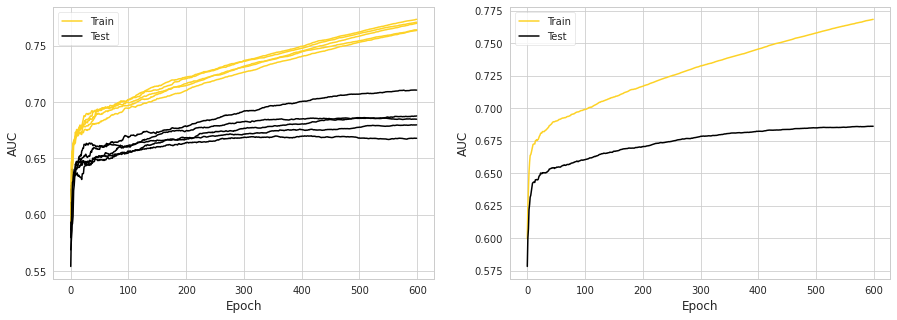

Mean of scorings: 0.1145


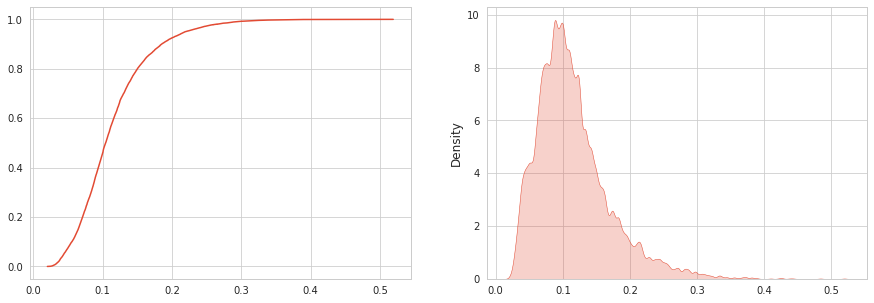

Blind test auc: 0.6848


True

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

In [37]:
clf.fit_model()

In [38]:
processed_data.head(1)

,level_0,index,pk,Monto_medio,Plazo_medio,Tasa_medio,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.householdEconomy.deposit,economics.householdEconomy.effortRate,economics.householdEconomy.homeNetIncome,economics.householdEconomy.incomeByRanges,economics.householdEconomy.newEffortRate,economics.householdEconomy.povertyThreshold,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.householdEconomy.probExpenseRestaurants,economics.householdEconomy.probExpenseTelco,economics.householdEconomy.probExpenseTransport,economics.householdEconomy.probExpenses,economics.householdEconomy.probSaving,economics.householdEconomy.sel,economics.housingData.bathShowerToilet,economics.housingData.codEntity,economics.housingData.codLocality,economics.housingData.codMunicipality,economics.housingData.housingType,economics.housingData.latitude,economics.housingData.locationSize,economics.housingData.longitude,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.id,economics.individualIncome,economics.modelV1IndividualIncome,economics.modelV2IndividualIncome,economics.rawIndividualIncome,economics.rent,economics.typeTable,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,geoCheck.parsedAddress.zipCode,geoCheck.score,fe_routlier_Monto_medio,fe_routlier_Plazo_medio,fe_missing_economics.familyData.numberOfChild,fe_loutlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDepYoung,fe_loutlier_economics.familyData.numberOfIndep,fe_routlier_economics.familyData.numberOfIndep,fe_loutlier_economics.familyData.numberOfParents,fe_routlier_economics.familyData.numberOfParents,fe_routlier_economics.householdEconomy.deposit,fe_routlier_economics.householdEconomy.effortRate,fe_routlier_economics.householdEconomy.homeNetIncome,fe_routlier_economics.householdEconomy.incomeByRanges,fe_routlier_economics.householdEconomy.newEffortRate,fe_routlier_economics.householdEconomy.povertyThreshold,fe_routlier_economics.householdEconomy.probExpenseAlcoholAndTobacco,fe_routlier_economics.householdEconomy.probExpenseClothesAndFootwear,fe_routlier_economics.householdEconomy.probExpenseEducation,fe_routlier_economics.householdEconomy.probExpenseFinancial,fe_routlier_economics.householdEconomy.probExpenseHealthCare,fe_routlier_economics.householdEconomy.probExpenseHealthInsurance,fe_routlier_economics.householdEconomy.probExpenseHomeRepair,fe_routlier_economics.householdEconomy.probExpenseHousesAndSupplies,fe_routlier_economics.householdEconomy.probExpenseLeisure,fe_routlier_economics.householdEconomy.probExpenseOthers,fe_routlier_economics.householdEconomy.probExpensePurchaseExp,fe_routlier_economics.householdEconomy.probExpenseRestaurants,fe_routlier_economics.householdEconomy.probExpenseTelco,fe_routlier_economics.householdEconomy.probExpenseTransport,fe_loutlier_economics.householdEconomy.probExpenses,fe_routlier_economics.householdEconomy.probExpenses,fe_loutlier_economics.householdEconomy.probSaving,fe_routlier_econ

In [39]:
processed_data.drop(columns='pk', inplace=True)

In [40]:
processed_data.head(1)

,level_0,index,Monto_medio,Plazo_medio,Tasa_medio,economics.familyData.numberOfChild,economics.familyData.numberOfDep,economics.familyData.numberOfDepYoung,economics.familyData.numberOfIndep,economics.familyData.numberOfParents,economics.familyData.numberOfYoungs,economics.familyData.typeMember,economics.householdEconomy.deposit,economics.householdEconomy.effortRate,economics.householdEconomy.homeNetIncome,economics.householdEconomy.incomeByRanges,economics.householdEconomy.newEffortRate,economics.householdEconomy.povertyThreshold,economics.householdEconomy.probExpenseAlcoholAndTobacco,economics.householdEconomy.probExpenseClothesAndFootwear,economics.householdEconomy.probExpenseEducation,economics.householdEconomy.probExpenseFinancial,economics.householdEconomy.probExpenseFood,economics.householdEconomy.probExpenseHealthCare,economics.householdEconomy.probExpenseHealthInsurance,economics.householdEconomy.probExpenseHomeRepair,economics.householdEconomy.probExpenseHousesAndSupplies,economics.householdEconomy.probExpenseLeisure,economics.householdEconomy.probExpenseOthers,economics.householdEconomy.probExpensePurchaseExp,economics.householdEconomy.probExpenseRestaurants,economics.householdEconomy.probExpenseTelco,economics.householdEconomy.probExpenseTransport,economics.householdEconomy.probExpenses,economics.householdEconomy.probSaving,economics.householdEconomy.sel,economics.housingData.bathShowerToilet,economics.housingData.codEntity,economics.housingData.codLocality,economics.housingData.codMunicipality,economics.housingData.housingType,economics.housingData.latitude,economics.housingData.locationSize,economics.housingData.longitude,economics.housingData.numberHouseholdCars,economics.housingData.numberHouseholdMembers,economics.housingData.numberHouseholdMembersNoOutliers,economics.housingData.numberIncandescentLights,economics.housingData.numberLowConsumptionLights,economics.housingData.numberRooms,economics.id,economics.individualIncome,economics.modelV1IndividualIncome,economics.modelV2IndividualIncome,economics.rawIndividualIncome,economics.rent,economics.typeTable,geoCheck.parsedAddress.latitude,geoCheck.parsedAddress.longitude,geoCheck.parsedAddress.zipCode,geoCheck.score,fe_routlier_Monto_medio,fe_routlier_Plazo_medio,fe_missing_economics.familyData.numberOfChild,fe_loutlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDep,fe_routlier_economics.familyData.numberOfDepYoung,fe_loutlier_economics.familyData.numberOfIndep,fe_routlier_economics.familyData.numberOfIndep,fe_loutlier_economics.familyData.numberOfParents,fe_routlier_economics.familyData.numberOfParents,fe_routlier_economics.householdEconomy.deposit,fe_routlier_economics.householdEconomy.effortRate,fe_routlier_economics.householdEconomy.homeNetIncome,fe_routlier_economics.householdEconomy.incomeByRanges,fe_routlier_economics.householdEconomy.newEffortRate,fe_routlier_economics.householdEconomy.povertyThreshold,fe_routlier_economics.householdEconomy.probExpenseAlcoholAndTobacco,fe_routlier_economics.householdEconomy.probExpenseClothesAndFootwear,fe_routlier_economics.householdEconomy.probExpenseEducation,fe_routlier_economics.householdEconomy.probExpenseFinancial,fe_routlier_economics.householdEconomy.probExpenseHealthCare,fe_routlier_economics.householdEconomy.probExpenseHealthInsurance,fe_routlier_economics.householdEconomy.probExpenseHomeRepair,fe_routlier_economics.householdEconomy.probExpenseHousesAndSupplies,fe_routlier_economics.householdEconomy.probExpenseLeisure,fe_routlier_economics.householdEconomy.probExpenseOthers,fe_routlier_economics.householdEconomy.probExpensePurchaseExp,fe_routlier_economics.householdEconomy.probExpenseRestaurants,fe_routlier_economics.householdEconomy.probExpenseTelco,fe_routlier_economics.householdEconomy.probExpenseTransport,fe_loutlier_economics.householdEconomy.probExpenses,fe_routlier_economics.householdEconomy.probExpenses,fe_loutlier_economics.householdEconomy.probSaving,fe_routlier_economi

In [41]:
processed_data.reset_index(inplace=True)

In [42]:
processed_data.to_csv('gs://hocelot_mx_analytics/mexico/output/mx-00007-Came/post_RDT_Came.csv', sep=';', index=False)

In [43]:
df_predicted_test = pd.read_csv('gs://hocelot_mx_analytics/mexico/output/mx-00007-Came/model_predictions.csv', sep = ',')

In [46]:
df_predicted_test = df_predicted_test.merge(processed_data[['pk','NoCliente','Default_90_dias_pers']], how='inner', on='pk')

In [47]:
df_predicted_test.to_csv('gs://hocelot_mx_analytics/mexico/output/mx-00007-Came/model_predictions.csv', sep = ',')

In [48]:
df_predicted_test[df_predicted_test['real_value']!=df_predicted_test['Default_90_dias_pers']]

,pk,proba,real_value,NoCliente,Default_90_dias_pers


In [44]:
print(df_predicted_test.shape)
df_predicted_test.head()

(13262, 3)


,pk,proba,real_value
0,2463,0.5193,1
1,11575,0.4837,0
2,13031,0.4428,1
3,1340,0.4381,0
4,13203,0.4269,0


In [45]:
plots = ModelResultsGrapher(df_predicted_test.real_value, df_predicted_test.proba, target_name='default')

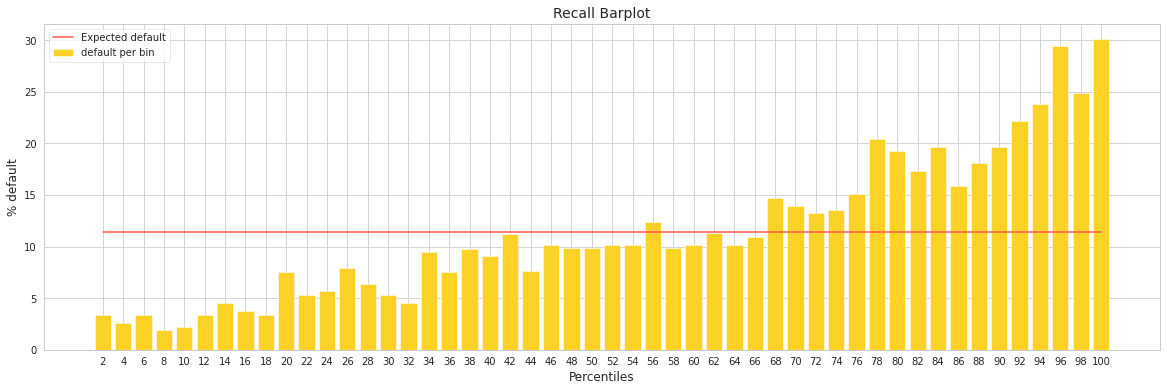

In [46]:
plots.bar_plot_gain()

In [47]:
roc_auc = roc_auc_score(df_predicted_test['real_value'], df_predicted_test['proba'])
print('Blind test auc: {0:.4f}'.format(roc_auc))

Blind test auc: 0.6848


AUC: 0.6848 Gini: 0.3696


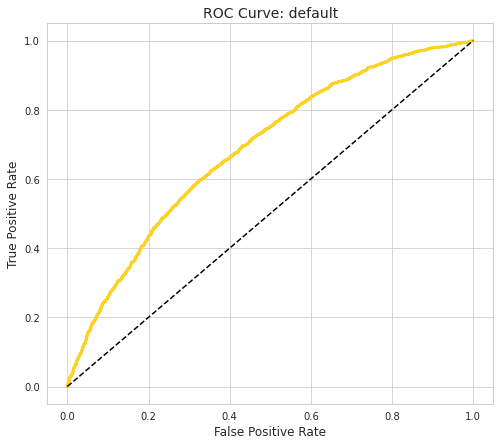

In [48]:
plots = ModelResultsGrapher(df_predicted_test.real_value, df_predicted_test.proba, target_name='default')
plots.roc_curve_with_auc_and_gini()

In [49]:
with open('gs://hocelot_mx_analytics/mexico/pickled_models/mx-00007-Came/xgb_model_total.pkl', 'rb') as model_file:
    clf = joblib.load(model_file)

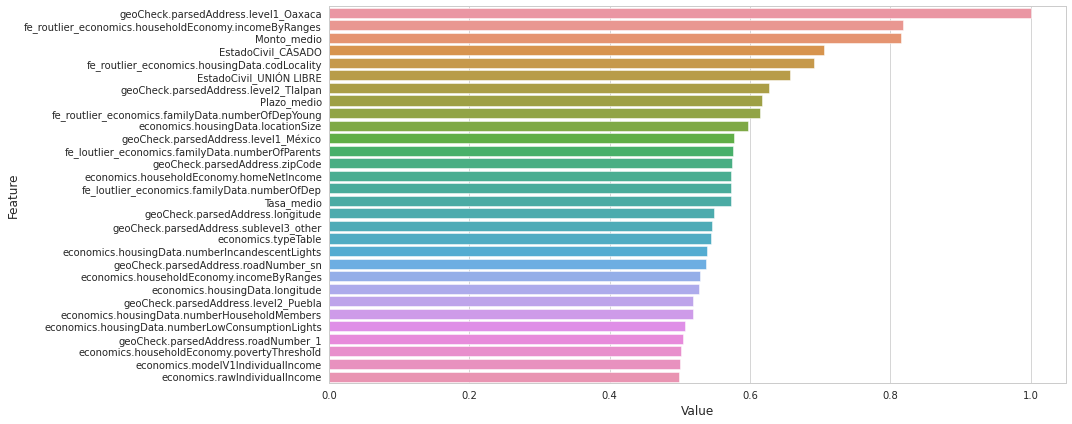

In [50]:
feature_importance = clf.feature_importances_
column_names = x_data.columns
feature_imp = pd.DataFrame(sorted(zip(feature_importance, column_names)), columns=['Value','Feature'])
feature_imp["Value"] = feature_imp["Value"]/max(feature_imp["Value"])
plt.figure(figsize=(15, 6))
sns.barplot(x="Value", y="Feature",data=feature_imp.sort_values(by="Value", ascending=False)[:30])
plt.tight_layout()
plt.show()

In [51]:
feature_imp

,Value,Feature
0,0.0000,economics.familyData.numberOfBabies_1.0
1,0.0000,economics.familyData.numberOfBabies_other
2,0.0000,economics.familyData.numberOfIndepYoung_0.0
3,0.0000,economics.familyData.numberOfIndepYoung_other
4,0.0000,economics.familyData.numberOfYoungs
5,0.0000,economics.householdEconomy.probExpenseAlcoholAndTobacco
6,0.0000,economics.householdEconomy.probExpenseHealthInsurance
7,0.0000,economics.housingData.bathShower_0.0
8,0.0000,economics.housingData.bathShower_other
9,0.0000,economics.housingData.car_0.0


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max